# Import

In [1]:
import pandas as pd
import numpy as np
import re
import string

from numpy import unique
from numpy import where
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Read Data

In [5]:
with open('/content/bbchealth.txt', 'r') as f:
    bbc = f.readlines()

regex = re.compile(r'(?P<tweet_id>.*)\|(?P<date>.*)\|(?P<news>.*)\s?(?P<link>http://.*)')

In [6]:
re.search(regex, bbc[0]).groupdict()

{'date': 'Thu Apr 09 01:31:50 +0000 2015',
 'link': 'http://bbc.in/1CimpJF',
 'news': 'Breast cancer risk test devised ',
 'tweet_id': '585978391360221184'}

In [7]:
df = pd.DataFrame(columns=['tweet_id', 'date', 'news', 'link'])

for line in bbc:
    line_data = re.search(regex, line).groupdict()
    df = df.append(line_data, ignore_index=True)

In [8]:
df.head()

,tweet_id,date,news,link
0,585978391360221184,Thu Apr 09 01:31:50 +0000 2015,Breast cancer risk test devised,http://bbc.in/1CimpJF
1,585947808772960257,Wed Apr 08 23:30:18 +0000 2015,GP workload harming care - BMA poll,http://bbc.in/1ChTBRv
2,585947807816650752,Wed Apr 08 23:30:18 +0000 2015,Short people's 'heart risk greater',http://bbc.in/1ChTANp
3,585866060991078401,Wed Apr 08 18:05:28 +0000 2015,New approach against HIV 'promising',http://bbc.in/1E6jAjt
4,585794106170839041,Wed Apr 08 13:19:33 +0000 2015,Coalition 'undermined NHS' - doctors,http://bbc.in/1CnLwK7


# Preprocessing

In [9]:
df.shape

(3929, 4)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  3929 non-null   object
 1   date      3929 non-null   object
 2   news      3929 non-null   object
 3   link      3929 non-null   object
dtypes: object(4)
memory usage: 122.9+ KB


In [11]:
df.isna().sum()

tweet_id    0
date        0
news        0
link        0
dtype: int64

In [12]:
df.duplicated().any()

False

In [13]:
lemmatizer = WordNetLemmatizer()

In [14]:
# Normalisasi, metode berikut secara berurutan --, hapus spasi, hapus tanda baca dan angka, dan terakhir tokenisasi kata
def normalize(line):
    line = line.lower().strip()
    line = ''.join([char for char in line if char not in string.punctuation+string.digits])
    return word_tokenize(line)

def lemmatize_sent(line_tokens):
    return list(map(lemmatizer.lemmatize, line_tokens))

def tokens(line_tokens):
    word_tags = pos_tag(line_tokens)
    return list(zip(*word_tags))[1]

In [15]:
# Buat kolom token, tag, token lemmatizing
df['news_tokens'] = df['news'].map(normalize)
df['corresponding_tags'] = df['news_tokens'].map(tokens)
df['lemmatized_news_tokens'] = df['news_tokens'].map(lemmatize_sent)

In [16]:
# Menghapus kolom yang tidak perlu
df.drop(labels=['link'], inplace=True, axis=1)
df.drop(labels=['tweet_id'], inplace=True, axis=1)

In [17]:
df.head()

,date,news,news_tokens,corresponding_tags,lemmatized_news_tokens
0,Thu Apr 09 01:31:50 +0000 2015,Breast cancer risk test devised,"[breast, cancer, risk, test, devised]","(NN, NN, NN, NN, VBD)","[breast, cancer, risk, test, devised]"
1,Wed Apr 08 23:30:18 +0000 2015,GP workload harming care - BMA poll,"[gp, workload, harming, care, bma, poll]","(NN, NN, VBG, NN, NN, NN)","[gp, workload, harming, care, bma, poll]"
2,Wed Apr 08 23:30:18 +0000 2015,Short people's 'heart risk greater',"[short, peoples, heart, risk, greater]","(JJ, NNS, NN, NN, JJR)","[short, people, heart, risk, greater]"
3,Wed Apr 08 18:05:28 +0000 2015,New approach against HIV 'promising',"[new, approach, against, hiv, promising]","(JJ, NN, IN, NN, NN)","[new, approach, against, hiv, promising]"
4,Wed Apr 08 13:19:33 +0000 2015,Coalition 'undermined NHS' - doctors,"[coalition, undermined, nhs, doctors]","(NN, VBD, JJ, NNS)","[coalition, undermined, nh, doctor]"


# TF-IDF & PCA

In [18]:
# Tranformasi dengan  membuat matriks tfidf dari semua dokumen
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['lemmatized_news_tokens'].map(lambda x: ' '.join(x)).tolist())

In [19]:
tfidf_matrix.shape

(3929, 3938)

In [20]:
tfidf_matrix = tfidf_matrix.todense()
tfidf_matrix

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
# Memangkas dimensi menjadi 2, karerna tfidf matrix memiliki dimensi yang terlalu besar yaitu 3929x3938
pca = PCA(n_components=2)
pca_matrix = pca.fit_transform(tfidf_matrix.A)

# AGNES

In [22]:
# Agnes Clustering menggunakan linkage distance
agnes = AgglomerativeClustering() #n_clusters = 2
a_fit = agnes.fit(tfidf_matrix)
p_fit = agnes.fit(pca_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [23]:
np.unique(agnes.labels_)

array([0, 1])

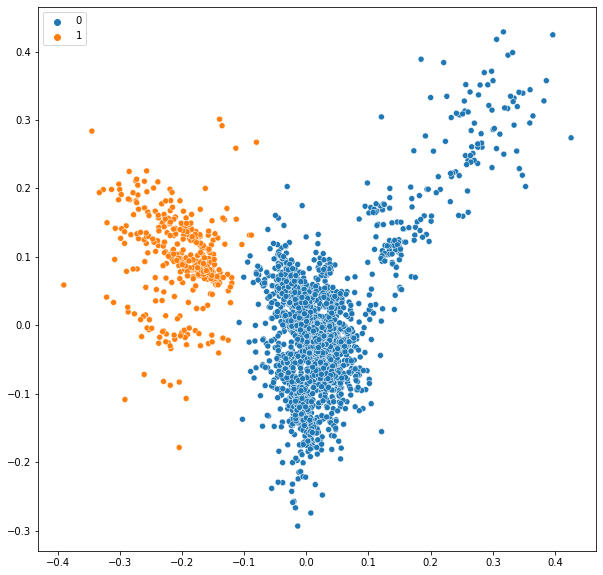

In [24]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=pca_matrix[:,0], y=pca_matrix[:,1], hue=agnes.labels_)

# Silhouette Score
Silhouette Coefficient atau Silhouette Score adalah metrik yang digunakan untuk menghitung kebaikan suatu teknik clustering. Nilainya berkisar dari -1 hingga 1.

In [25]:
for k in range(2, 16):
    agnes = AgglomerativeClustering(n_clusters=k).fit(pca_matrix)
    sil_score = silhouette_score(pca_matrix, agnes.labels_)
    print('Number of clusters: {}, Silhoutte Score: {}'.format(k, sil_score))

Number of clusters: 2, Silhoutte Score: 0.6387493203316859
Number of clusters: 3, Silhoutte Score: 0.6812231839350404
Number of clusters: 4, Silhoutte Score: 0.4150551057818054
Number of clusters: 5, Silhoutte Score: 0.4544079905921103
Number of clusters: 6, Silhoutte Score: 0.4606991295138504
Number of clusters: 7, Silhoutte Score: 0.42870341334921375
Number of clusters: 8, Silhoutte Score: 0.4123809268659668
Number of clusters: 9, Silhoutte Score: 0.42595017719855366
Number of clusters: 10, Silhoutte Score: 0.4284804690456733
Number of clusters: 11, Silhoutte Score: 0.4372285067034108
Number of clusters: 12, Silhoutte Score: 0.43084241515531674
Number of clusters: 13, Silhoutte Score: 0.4341644523094845
Number of clusters: 14, Silhoutte Score: 0.431640993579177
Number of clusters: 15, Silhoutte Score: 0.4057180232691567
